# Import necessary libraries

In [11]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D, Add, Multiply, Activation, Reshape, Concatenate, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import itertools

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print('Modules loaded')

Modules loaded


# Load and preprocess data

In [12]:
data_dir = 'data/CXR-PCT/train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Create dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

# EDA: Analyze Class Distribution

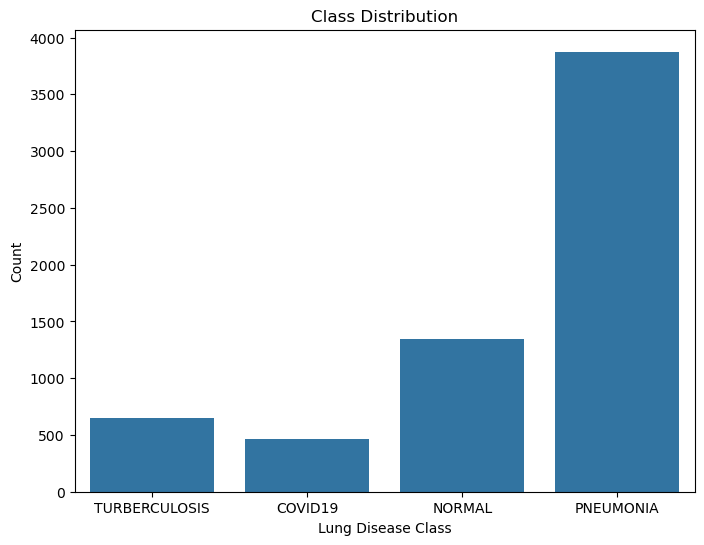

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x='labels', data=df)
plt.title('Class Distribution')
plt.xlabel('Lung Disease Class')
plt.ylabel('Count')
plt.show()

# Check for missing values

In [14]:
missing_values = df.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

Missing Values in Each Column:
 filepaths    0
labels       0
dtype: int64


# Display random samples from each class


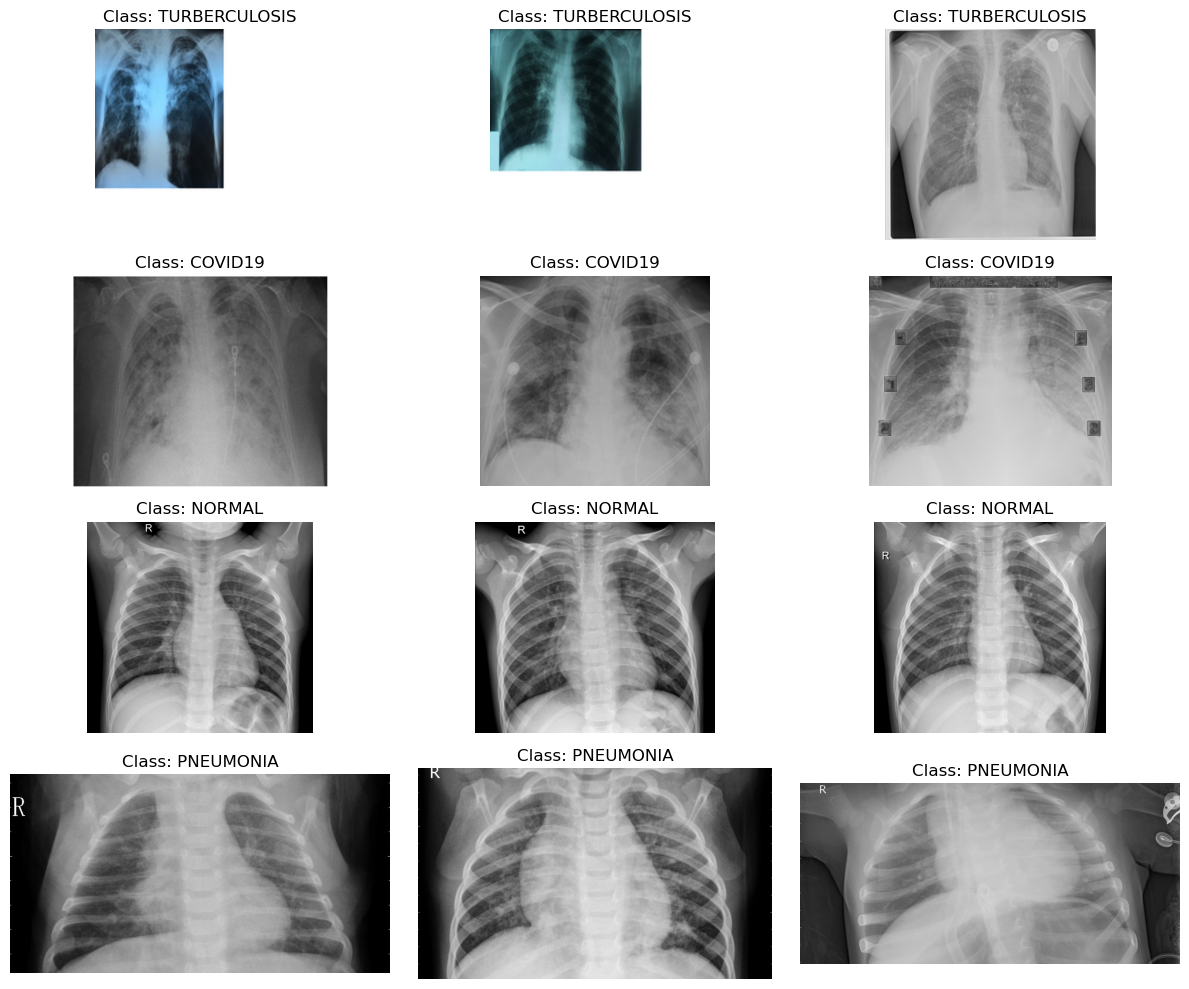

In [15]:
samples_per_class = 3
fig, ax = plt.subplots(len(df['labels'].unique()), samples_per_class, figsize=(12, 10))
for i, label in enumerate(df['labels'].unique()):
    samples = df[df['labels'] == label].sample(samples_per_class)
    for j in range(samples_per_class):
        img = plt.imread(samples.iloc[j]['filepaths'])
        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].set_title(f'Class: {label}')
        ax[i, j].axis('off')
plt.tight_layout()
plt.show()

In [16]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 5060 validated image filenames belonging to 4 classes.
Found 759 validated image filenames belonging to 4 classes.
Found 507 validated image filenames belonging to 4 classes.


# Model Structure¶


In [17]:
# Define CBAM Block
def cbam_block(input_tensor, ratio=8):
    # Channel Attention Module
    channel_avg_pool = GlobalAveragePooling2D()(input_tensor)
    channel_max_pool = GlobalMaxPooling2D()(input_tensor)
    shared_dense_one = Dense(input_tensor.shape[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_dense_two = Dense(input_tensor.shape[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=True)

    avg_out = shared_dense_one(channel_avg_pool)
    avg_out = shared_dense_two(avg_out)
    max_out = shared_dense_one(channel_max_pool)
    max_out = shared_dense_two(max_out)

    channel_attention = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_attention = Reshape((1, 1, input_tensor.shape[-1]))(channel_attention)
    channel_refined = Multiply()([input_tensor, channel_attention])

    # Spatial Attention Module
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    spatial_refined = Multiply()([channel_refined, spatial_attention])

    return spatial_refined

# Create Model Structure with CBAM
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet", input_shape=img_shape)

# Add CBAM Block after the base model
x = base_model.output
x = cbam_block(x)  # Apply CBAM block
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = GlobalAveragePooling2D()(x)

# Add Fully Connected Layers with Correct Regularization
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), 
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)

# Define and compile the model
model = Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

# Train model

In [18]:
# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model with class weights
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


Epoch 1/100


2024-10-21 04:22:50.748755: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-10-21 04:22:51.594678: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-10-21 04:22:51.601577: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-10-21 04:22:51.747855: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-10-21 04:22:51.747894: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generat

317/317 [==============================] - 39s 87ms/step - loss: 2.8985 - accuracy: 0.9362 - precision: 0.9531 - recall: 0.9111 - auc: 0.9919 - val_loss: 1.0555 - val_accuracy: 0.9605 - val_precision: 0.9665 - val_recall: 0.9513 - val_auc: 0.9972 - lr: 0.0010
Epoch 2/100
317/317 [==============================] - 27s 84ms/step - loss: 0.6330 - accuracy: 0.9741 - precision: 0.9792 - recall: 0.9694 - auc: 0.9979 - val_loss: 0.3733 - val_accuracy: 0.9776 - val_precision: 0.9789 - val_recall: 0.9776 - val_auc: 0.9990 - lr: 0.0010
Epoch 3/100
317/317 [==============================] - 27s 84ms/step - loss: 0.2926 - accuracy: 0.9848 - precision: 0.9871 - recall: 0.9826 - auc: 0.9993 - val_loss: 0.2217 - val_accuracy: 0.9908 - val_precision: 0.9921 - val_recall: 0.9895 - val_auc: 0.9995 - lr: 0.0010
Epoch 4/100
317/317 [==============================] - 27s 84ms/step - loss: 0.2062 - accuracy: 0.9897 - precision: 0.9917 - recall: 0.9874 - auc: 0.9992 - val_loss: 0.1619 - val_accuracy: 0.9947 

In [19]:
# Evaluate model
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

13/13 [==============================] - 2s 139ms/step - loss: 0.0672 - accuracy: 0.9961 - precision: 0.9960 - recall: 0.9941 - auc: 0.9977
Train Loss:  0.04130139201879501
Train Accuracy:  1.0
--------------------
Validation Loss:  0.04346676915884018
Validation Accuracy:  1.0
--------------------
Test Loss:  0.06719761341810226
Test Accuracy:  0.9960552453994751


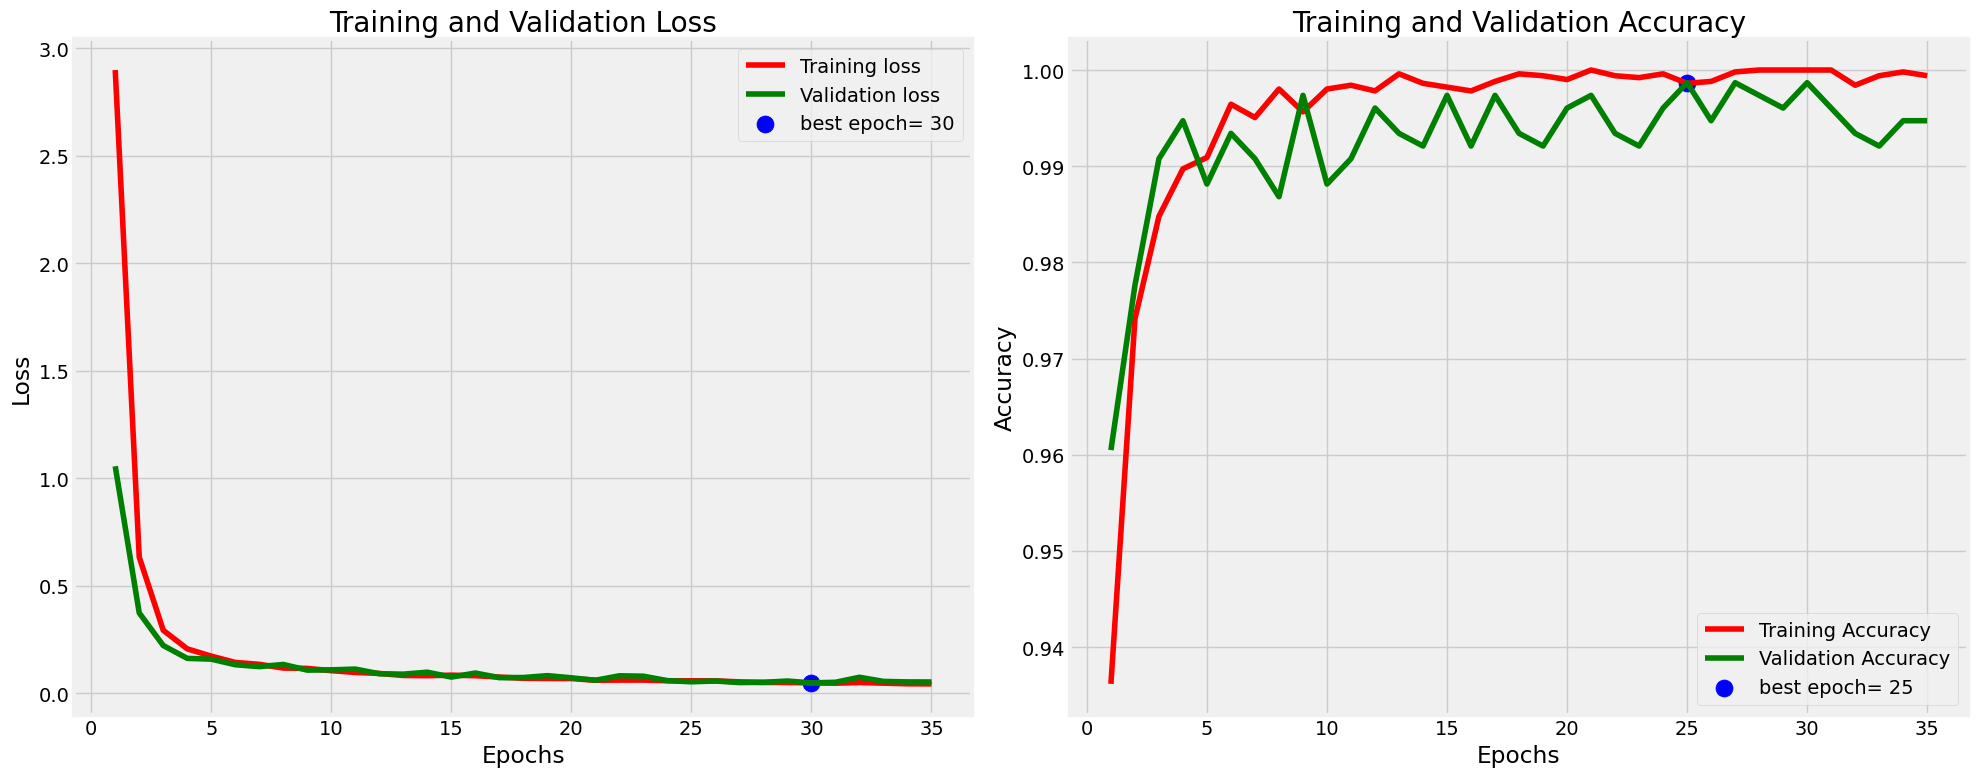

In [20]:
# Plot Training History
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


13/13 [==============================] - 2s 149ms/step


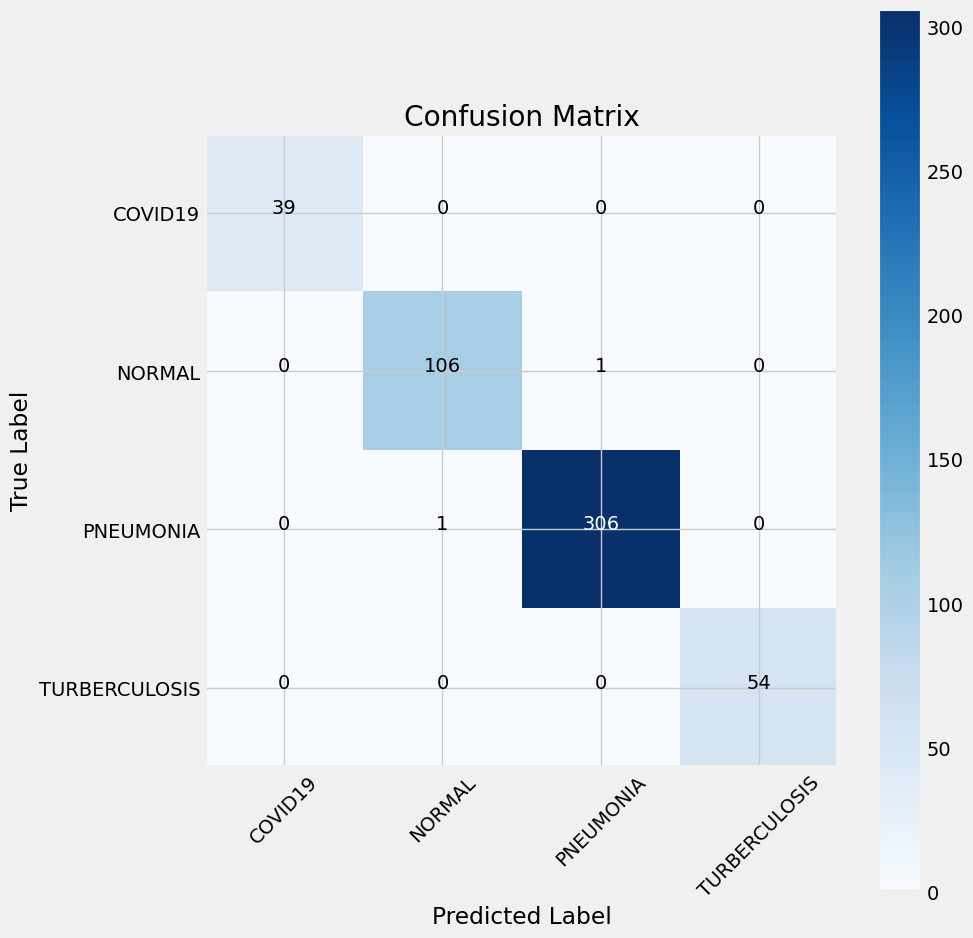

               precision    recall  f1-score   support

      COVID19       1.00      1.00      1.00        39
       NORMAL       0.99      0.99      0.99       107
    PNEUMONIA       1.00      1.00      1.00       307
TURBERCULOSIS       1.00      1.00      1.00        54

     accuracy                           1.00       507
    macro avg       1.00      1.00      1.00       507
 weighted avg       1.00      1.00      1.00       507



In [21]:
# Generate Predictions
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Confusion Matrix and Classification Report
classes = list(train_gen.class_indices.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(test_gen.classes, y_pred, target_names=classes))


In [22]:
# Save final model
model_name = "XRayClassifier-CBAM-EfficientNetB0"
acc = test_score[1] * 100
save_path = ''
save_id = f'{model_name}-{"%.2f" % round(acc, 2)}.h5'
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'Model was saved as {model_save_loc}')

# Save model weights
weight_save_id = f'{model_name}-weights.weights.h5'
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'Weights were saved as {weights_save_loc}')

# Generate CSV files containing class indices and image size
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = [img_size[0]] * len(class_dict)
width = [img_size[1]] * len(class_dict)

Index_series = pd.Series(list(class_dict.values()), name='class_index')
Class_series = pd.Series(list(class_dict.keys()), name='class')
Height_series = pd.Series(height, name='height')
Width_series = pd.Series(width, name='width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis=1)
csv_name = f'{model_name}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index=False)
print(f'Class CSV file was saved as {csv_save_loc}')

Model was saved as XRayClassifier-CBAM-EfficientNetB0-99.61.h5
Weights were saved as XRayClassifier-CBAM-EfficientNetB0-weights.weights.h5
Class CSV file was saved as XRayClassifier-CBAM-EfficientNetB0-class_dict.csv


In [26]:
import numpy as np
import pandas as pd
import logging
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Configure logging to log predictions and issues
logging.basicConfig(filename='model_predictions.log', level=logging.INFO, 
                    format='%(asctime)s %(message)s')

# Step 1: Load the Model and Weights
try:
    model = load_model('XRayClassifier-CBAM-EfficientNetB0-99.61.h5')
    model.load_weights('XRayClassifier-CBAM-EfficientNetB0-weights.weights.h5')
    print("Model and weights loaded successfully.")
except Exception as e:
    print(f"Error loading model or weights: {e}")
    logging.error(f"Error loading model or weights: {e}")
    exit()

# Step 2: Load the Class Dictionary CSV
try:
    class_dict = pd.read_csv('XRayClassifier-CBAM-EfficientNetB0-class_dict.csv')
    class_labels = dict(zip(class_dict['class_index'], class_dict['class']))
    print("Class labels loaded successfully.")
except Exception as e:
    print(f"Error loading class dictionary: {e}")
    logging.error(f"Error loading class dictionary: {e}")
    exit()

# Step 3: Preprocess Input Image
def preprocess_image(img_path):
    try:
        if isinstance(img_path, str):
            img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
            img_array = preprocess_input(img_array)  # Preprocess for EfficientNet
            return img_array
        else:
            raise ValueError(f"Invalid input type. Expected a string path, got {type(img_path)}.")
    except Exception as e:
        print(f"Error processing image: {e}")
        logging.error(f"Error processing image at {img_path}: {e}")
        return None

# Step 4: Display Predictions with Confidence
def display_predictions(img_path, threshold=0.5):
    img_array = preprocess_image(img_path)
    
    if img_array is not None:
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_confidence = predictions[0][predicted_class_index]

        # Step 4a: Add threshold check for low confidence predictions
        if predicted_confidence < threshold:
            print(f"Model confidence is too low ({predicted_confidence * 100:.2f}%). Prediction might be uncertain.")
            logging.warning(f"Low confidence ({predicted_confidence * 100:.2f}%) for image: {img_path}")
        else:
            print(f"Predicted Class: {class_labels[predicted_class_index]} (Confidence: {predicted_confidence * 100:.2f}%)")
            logging.info(f"Predicted Class: {class_labels[predicted_class_index]} (Confidence: {predicted_confidence * 100:.2f}%) for image: {img_path}")

        # Step 4b: Display top 3 predictions regardless of confidence
        top_indices = predictions[0].argsort()[-3:][::-1]
        top_classes = [(class_labels[i], predictions[0][i]) for i in top_indices]
        print("Top 3 Predictions:")
        for i, (label, confidence) in enumerate(top_classes, 1):
            print(f"{i}. {label} - Confidence: {confidence * 100:.2f}%")

        # Step 4c: Visualize the prediction with the image
        visualize_prediction(img_path, top_classes)

    else:
        print("Image could not be processed. Please check the image file.")
        logging.error(f"Image processing failed for {img_path}")

# Step 5: Visualize Predictions with the Image
def visualize_prediction(img_path, top_classes):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        plt.imshow(img)
        plt.title(f"Predicted: {top_classes[0][0]} ({top_classes[0][1] * 100:.2f}%)")
        
        # Optionally, add text for the top 3 predictions
        for i, (label, confidence) in enumerate(top_classes):
            plt.text(10, (i + 1) * 20, f"{label}: {confidence * 100:.2f}%", fontsize=12, color='white', 
                     bbox=dict(facecolor='blue', alpha=0.5))
        plt.show()
    except Exception as e:
        print(f"Error visualizing the image: {e}")
        logging.error(f"Error visualizing the image at {img_path}: {e}")

# Step 6: Batch Prediction for Multiple Images
def batch_predict(image_paths, threshold=0.5):
    # Ensure we are only processing valid image paths
    images = []
    valid_image_paths = []
    
    for img_path in image_paths:
        img_array = preprocess_image(img_path)
        if img_array is not None:
            images.append(img_array)
            valid_image_paths.append(img_path)  # Track only valid images

    if images:
        images = np.vstack(images)  # Stack images into a single batch for prediction
        predictions = model.predict(images)

        for i, img_path in enumerate(valid_image_paths):  # Use valid_image_paths instead of image_paths
            top_indices = predictions[i].argsort()[-3:][::-1]
            top_classes = [(class_labels[index], predictions[i][index]) for index in top_indices]
            predicted_class_index = np.argmax(predictions[i], axis=0)
            confidence = predictions[i][predicted_class_index]

            # Confidence threshold check
            if confidence < threshold:
                print(f"\nLow confidence prediction for {img_path}. Confidence: {confidence * 100:.2f}%")
                logging.warning(f"Low confidence prediction for {img_path}. Confidence: {confidence * 100:.2f}%")
            else:
                print(f"\nResults for {img_path}:")
                print(f"Predicted Class: {class_labels[predicted_class_index]} (Confidence: {confidence * 100:.2f}%)")
                logging.info(f"Predicted Class: {class_labels[predicted_class_index]} (Confidence: {confidence * 100:.2f}%) for {img_path}")
                
            print("Top 3 Predictions:")
            for j, (label, confidence) in enumerate(top_classes, 1):
                print(f"{j}. {label} - Confidence: {confidence * 100:.2f}%")
    else:
        print("No valid images to process.")
        logging.error("No valid images to process.")

Model and weights loaded successfully.
Class labels loaded successfully.


1/1 [==============================] - 1s 618ms/step
Predicted Class: TURBERCULOSIS (Confidence: 99.90%)
Top 3 Predictions:
1. TURBERCULOSIS - Confidence: 99.90%
2. COVID19 - Confidence: 0.04%
3. PNEUMONIA - Confidence: 0.04%


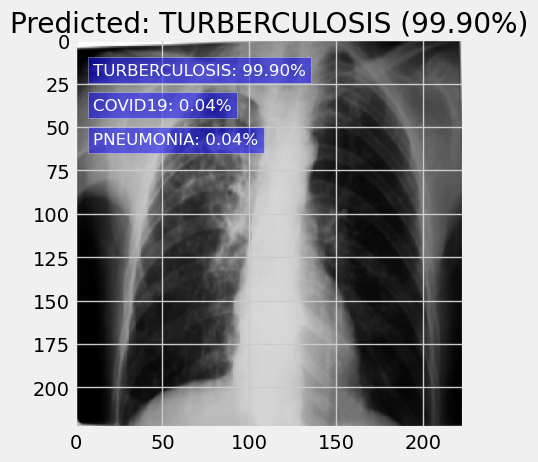

In [24]:
# Single image prediction
image_path = 'test/TURBERCULOSIS/Tuberculosis-660.png'  
display_predictions(image_path)



1/1 [==============================] - 0s 478ms/step
Predicted Class: PNEUMONIA (Confidence: 99.78%)
Top 3 Predictions:
1. PNEUMONIA - Confidence: 99.78%
2. NORMAL - Confidence: 0.12%
3. COVID19 - Confidence: 0.06%


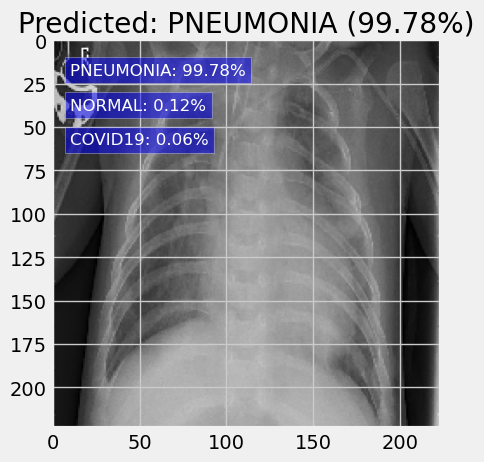

In [27]:
# Single image prediction
image_path = 'data/CXR-PCT/test/PNEUMONIA/person1_virus_8.jpeg'  
display_predictions(image_path)

1/1 [==============================] - 0s 20ms/step
Predicted Class: NORMAL (Confidence: 99.49%)
Top 3 Predictions:
1. NORMAL - Confidence: 99.49%
2. PNEUMONIA - Confidence: 0.41%
3. COVID19 - Confidence: 0.06%


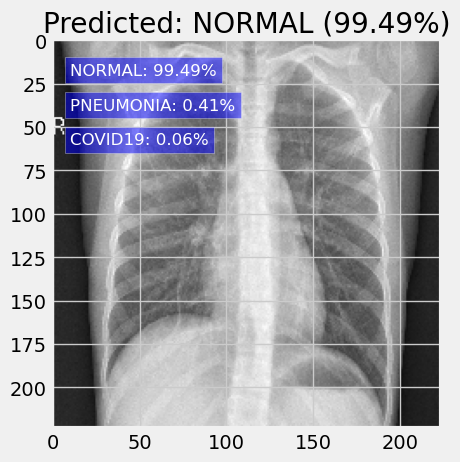

In [28]:
# Single image prediction
image_path = 'data/CXR-PCT/test/NORMAL/IM-0003-0001.jpeg'  
display_predictions(image_path)

1/1 [==============================] - 0s 20ms/step
Predicted Class: COVID19 (Confidence: 99.74%)
Top 3 Predictions:
1. COVID19 - Confidence: 99.74%
2. PNEUMONIA - Confidence: 0.11%
3. TURBERCULOSIS - Confidence: 0.08%


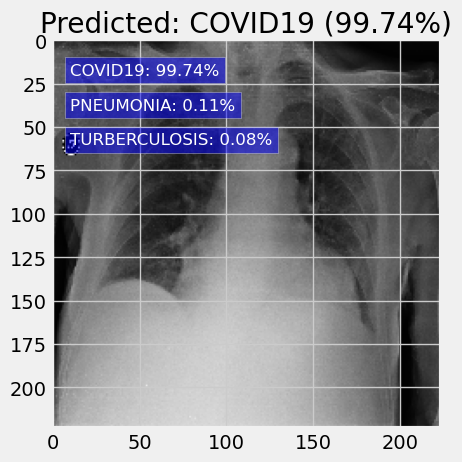

In [29]:
# Single image prediction
image_path = 'data/CXR-PCT/test/COVID19/COVID19(461).jpg'  
display_predictions(image_path)

In [25]:
# Batch processing for multiple images
# cimage_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']  # Replace with your actual image paths
# batch_predict(image_paths)